In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import History
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv(r'data\finaldf_train.csv')
test = pd.read_csv(r'data\finaldf_test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3389 entries, 0 to 3388
Data columns (total 76 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              3389 non-null   int64  
 1   id                                      3389 non-null   float64
 2   runtime                                 3389 non-null   float64
 3   title                                   3389 non-null   object 
 4   budget_adj                              3389 non-null   float64
 5   revenue_adj                             3389 non-null   float64
 6   Action                                  3389 non-null   int64  
 7   Adventure                               3389 non-null   int64  
 8   Animation                               3389 non-null   int64  
 9   Comedy                                  3389 non-null   int64  
 10  Crime                                   3389 non-null   int6

In [4]:
#Apply standardisation on numerical cols and log10 on budget and revenue
df_train['log_revenue_adj'] = df_train['revenue_adj'].apply(lambda x: np.log10(x+1))
test['log_revenue_adj'] = test['revenue_adj'].apply(lambda x: np.log10(x+1))

df_train['log_budget_adj'] = df_train['budget_adj'].apply(lambda x: np.log10(x+1))
test['log_budget_adj'] = test['budget_adj'].apply(lambda x: np.log10(x+1))

cscaler = StandardScaler()
cscaler.fit(df_train[['total_cast']])
df_train['st_total_cast'] = cscaler.transform(df_train[['total_cast']])
test['st_total_cast'] = cscaler.transform(test[['total_cast']])

rscaler = StandardScaler()
rscaler.fit(df_train[['runtime']])
df_train['st_runtime'] = rscaler.transform(df_train[['runtime']])
test['st_runtime'] = rscaler.transform(test[['runtime']])

When tuning the neural network, we need a validation dataset to provide an unbiased estimate of the performance of the model.

In [5]:
#Create validation data from test data (train 0.7, test 0.2, val 0.1)
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'log_revenue_adj', 'revenue_adj', 'budget_adj', 'total_cast', 
                                 'runtime', 'series_ind'])
y_train = df_train['log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'log_revenue_adj', 'revenue_adj', 'budget_adj', 'total_cast', 
                                 'runtime', 'series_ind'])
y_test = df_test['log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'log_revenue_adj', 'revenue_adj', 'budget_adj', 'total_cast', 
                                 'runtime', 'series_ind'])
y_val = df_val['log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [6]:
X_train.shape[1]

71

Regression with all input variables and 3 layers.

In [7]:
#Define model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output unit for regression

# compile and train model
model.compile(optimizer='adam', loss='mean_squared_error')
model_hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 6ms/step - loss: 7.0342 - val_loss: 0.7891
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6401 - val_loss: 0.6779
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5591 - val_loss: 0.6322
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5272 - val_loss: 0.6145
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5122 - val_loss: 0.6187
Epoch 6/10
106/106 [==============================] - 0s 4ms/step - loss: 0.5032 - val_loss: 0.6127
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4962 - val_loss: 0.6030
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4886 - val_loss: 0.6046
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4858 - val_loss: 0.6043
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5799536849167

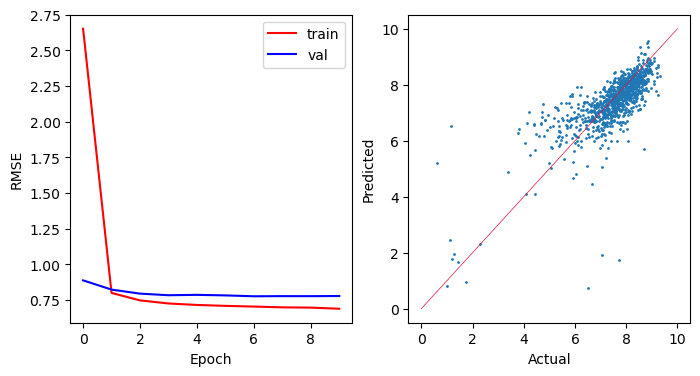

In [8]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

The neural network appears to have completed most of the learning in the first epoch, which could indicate that the network is not deep enough.

### Vary Number of Layers

In [9]:
# 2 layers
model1 = Sequential()
model1.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(1))

model1.compile(optimizer='adam', loss='mean_squared_error')
model1_hist=model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)

Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 14.4197 - val_loss: 0.9644
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.8037 - val_loss: 0.7889
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6887 - val_loss: 0.7241
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6298 - val_loss: 0.6873
Epoch 5/10
106/106 [==============================] - 0s 2ms/step - loss: 0.5936 - val_loss: 0.6645
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5660 - val_loss: 0.6494
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5470 - val_loss: 0.6490
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5325 - val_loss: 0.6302
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5233 - val_loss: 0.6307
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.565310364405

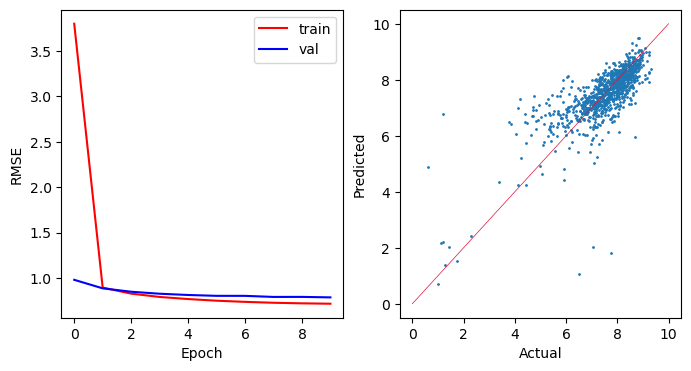

In [10]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model1_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model1_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [11]:
#4 layers
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1))

model1.compile(optimizer='adam', loss='mean_squared_error')
model1_hist=model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)

Epoch 1/10
106/106 [==============================] - 2s 6ms/step - loss: 4.9317 - val_loss: 0.7893
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6021 - val_loss: 0.6773
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5481 - val_loss: 0.6389
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5288 - val_loss: 0.6429
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5187 - val_loss: 0.6126
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5070 - val_loss: 0.6099
Epoch 7/10
106/106 [==============================] - 0s 4ms/step - loss: 0.4958 - val_loss: 0.6221
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4849 - val_loss: 0.6062
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4790 - val_loss: 0.5975
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5805829775842

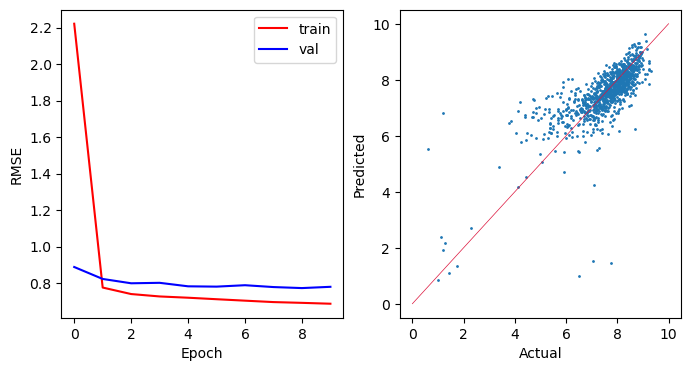

In [12]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model1_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model1_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [13]:
#5 layers
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1))

model1.compile(optimizer='adam', loss='mean_squared_error')
model1_hist=model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)

Epoch 1/10
106/106 [==============================] - 3s 6ms/step - loss: 11.6262 - val_loss: 0.7461
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6143 - val_loss: 0.6750
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5568 - val_loss: 0.6571
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5279 - val_loss: 0.6380
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5190 - val_loss: 0.6300
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5121 - val_loss: 0.6293
Epoch 7/10
106/106 [==============================] - 0s 4ms/step - loss: 0.5030 - val_loss: 0.6319
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5050 - val_loss: 0.6504
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4922 - val_loss: 0.6271
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.560656007654

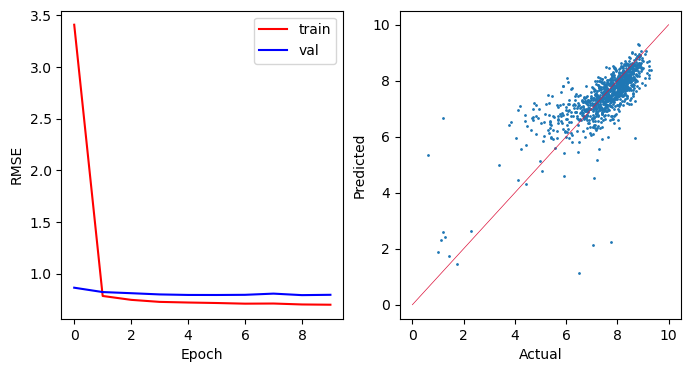

In [14]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model1_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model1_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [15]:
#6 relu layers
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(4, activation='relu'))
model1.add(Dense(1))

model1.compile(optimizer='adam', loss='mean_squared_error')
model1_hist=model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)

Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 12.3633 - val_loss: 0.8539
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6739 - val_loss: 0.7292
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5939 - val_loss: 0.6667
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5490 - val_loss: 0.6434
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5295 - val_loss: 0.6163
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5167 - val_loss: 0.6063
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5070 - val_loss: 0.5977
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4998 - val_loss: 0.6001
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4923 - val_loss: 0.6077
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.594525707603

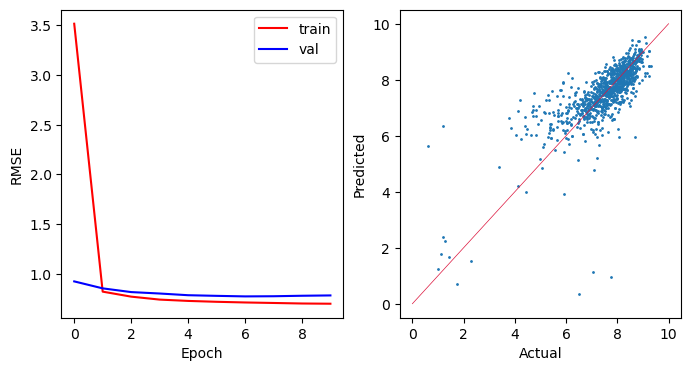

In [16]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model1_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model1_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

Increasing the number of layers to 6 appears to have a detrimental effect on model fit. There does not appear to be significant improvement in performance for 3-5 layers, so a simpler network would be preferrred.

### Vary Batch Size

In [17]:
#batch size = 16
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error')
model2_hist=model2.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)

Epoch 1/10
212/212 [==============================] - 2s 4ms/step - loss: 4.1681 - val_loss: 0.6910
Epoch 2/10
212/212 [==============================] - 1s 3ms/step - loss: 0.5566 - val_loss: 0.6358
Epoch 3/10
212/212 [==============================] - 1s 3ms/step - loss: 0.5270 - val_loss: 0.6260
Epoch 4/10
212/212 [==============================] - 1s 3ms/step - loss: 0.5184 - val_loss: 0.6303
Epoch 5/10
212/212 [==============================] - 1s 3ms/step - loss: 0.5129 - val_loss: 0.6184
Epoch 6/10
212/212 [==============================] - 1s 3ms/step - loss: 0.5141 - val_loss: 0.6185
Epoch 7/10
212/212 [==============================] - 1s 3ms/step - loss: 0.4923 - val_loss: 0.6523
Epoch 8/10
212/212 [==============================] - 1s 3ms/step - loss: 0.4920 - val_loss: 0.6234
Epoch 9/10
212/212 [==============================] - 1s 3ms/step - loss: 0.4851 - val_loss: 0.6391
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5835888032599

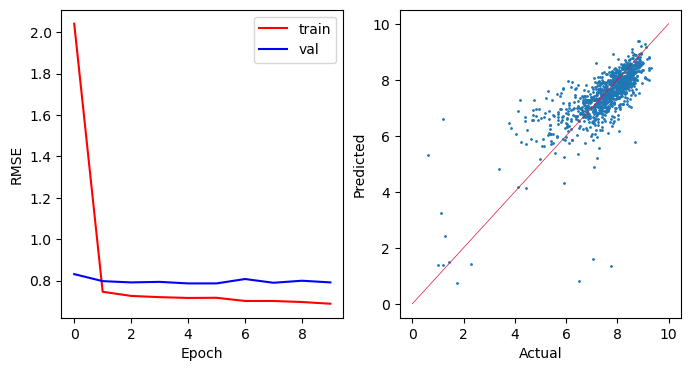

In [18]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model2_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model2_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [19]:
#batch size = 64
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error')
model2_hist=model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)

Epoch 1/10
53/53 [==============================] - 2s 7ms/step - loss: 28.8574 - val_loss: 1.2262
Epoch 2/10
53/53 [==============================] - 0s 4ms/step - loss: 0.9588 - val_loss: 0.8550
Epoch 3/10
53/53 [==============================] - 0s 4ms/step - loss: 0.7068 - val_loss: 0.7688
Epoch 4/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6473 - val_loss: 0.7241
Epoch 5/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6074 - val_loss: 0.6857
Epoch 6/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5677 - val_loss: 0.6449
Epoch 7/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5426 - val_loss: 0.6310
Epoch 8/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5266 - val_loss: 0.6205
Epoch 9/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5145 - val_loss: 0.6198
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5869126183734925
test r-square

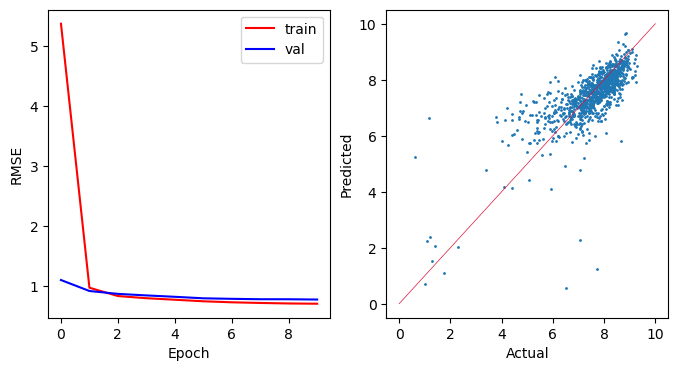

In [20]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model2_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model2_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

### Vary Activation Function

In [21]:
#no activation function
model2 = Sequential()
model2.add(Dense(64, input_shape=(X_train.shape[1],)))
model2.add(Dense(32))
model2.add(Dense(1))  # Single output unit for regression

# compile and train model
model2.compile(optimizer='adam', loss='mean_squared_error')
model2_hist = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 4.1264 - val_loss: 0.6941
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5854 - val_loss: 0.6362
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5527 - val_loss: 0.6349
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5410 - val_loss: 0.6252
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5354 - val_loss: 0.6229
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5359 - val_loss: 0.6191
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5411 - val_loss: 0.6232
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5389 - val_loss: 0.6417
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5417 - val_loss: 0.6402
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5897894587350

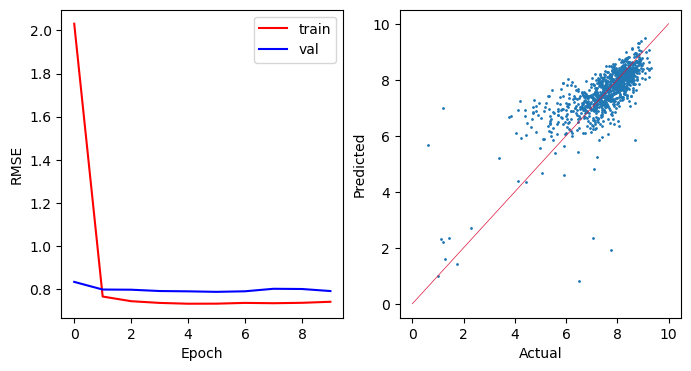

In [22]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model2_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model2_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [23]:
#no activation function, 4 layers
model2 = Sequential()
model2.add(Dense(64, input_shape=(X_train.shape[1],)))
model2.add(Dense(32))
model2.add(Dense(16))
model2.add(Dense(1))  # Single output unit for regression

# compile and train model
model2.compile(optimizer='adam', loss='mean_squared_error')
model2_hist = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 6.0749 - val_loss: 0.6503
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5736 - val_loss: 0.6214
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5439 - val_loss: 0.6123
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5341 - val_loss: 0.6149
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5363 - val_loss: 0.6189
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5352 - val_loss: 0.6206
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5400 - val_loss: 0.6171
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5343 - val_loss: 0.6201
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5420 - val_loss: 0.6289
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5884751832835

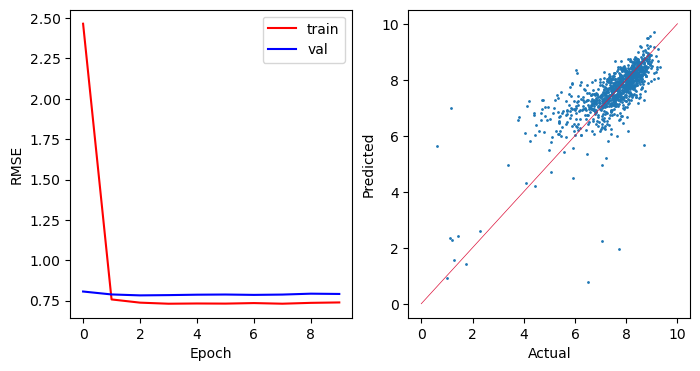

In [24]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model2_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model2_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [25]:
#some leaky relu
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(32, activation='leaky_relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1))  # Single output unit for regression

# compile and train model
model2.compile(optimizer='adam', loss='mean_squared_error')
model2_hist = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 6.6425 - val_loss: 0.7714
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6378 - val_loss: 0.6865
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5663 - val_loss: 0.6445
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5460 - val_loss: 0.6264
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5219 - val_loss: 0.6195
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5114 - val_loss: 0.6139
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.5117 - val_loss: 0.6164
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4949 - val_loss: 0.6278
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4901 - val_loss: 0.6210
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5929024322308

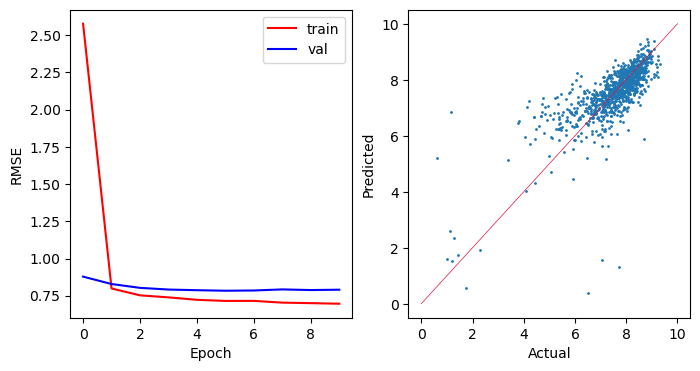

In [26]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model2_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model2_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([0, 10], [0,10], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

All the models seem to be converging after only 1 epoch. Since increasing complexity of the model does not appear to affect fit, it could be that the inputs are incorrectly specified.

### Standard scale all non one-hot encoded variables

In [27]:
lbscaler = StandardScaler()
lbscaler.fit(df_train[['log_budget_adj']])
df_train['st_log_budget_adj'] = lbscaler.transform(df_train[['log_budget_adj']])
test['st_log_budget_adj'] = lbscaler.transform(test[['log_budget_adj']])

lrscaler = StandardScaler()
lrscaler.fit(df_train[['log_revenue_adj']])
df_train['st_log_revenue_adj'] = lrscaler.transform(df_train[['log_revenue_adj']])
test['st_log_revenue_adj'] = lrscaler.transform(test[['log_revenue_adj']])

pscaler = StandardScaler()
pscaler.fit(df_train[['total_popular_cast']])
df_train['st_total_popular_cast'] = pscaler.transform(df_train[['total_popular_cast']])
test['st_total_popular_cast'] = pscaler.transform(test[['total_popular_cast']])


In [28]:
#Create validation data from test data (train 0.7, test 0.2, val 0.1)
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind'])
y_train = df_train['st_log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind'])
y_test = df_test['st_log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind'])
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [29]:
print(len(df_test), len(df_val))

968 478


In [30]:
model4 = Sequential()
model4.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(1)) 

# compile and train model
model4.compile(optimizer='adam', loss='mean_squared_error')
model4_hist = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model4.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 0.5499 - val_loss: 0.4730
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4148 - val_loss: 0.4626
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3955 - val_loss: 0.4490
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3831 - val_loss: 0.4514
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3762 - val_loss: 0.4587
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3705 - val_loss: 0.4645
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3542 - val_loss: 0.4582
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3489 - val_loss: 0.4676
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3486 - val_loss: 0.4588
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4318687547863

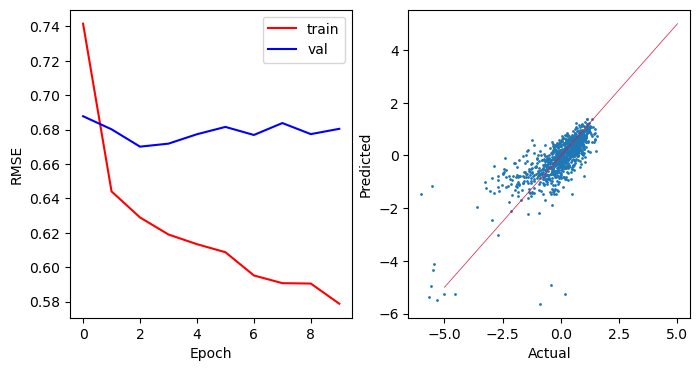

In [31]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model4_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model4_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

Model is now overfitting because training loss is decreasing but validation loss remains high. We can adjust the complexity of the model by changing the number of parameters to be learned. We should also reduce the number of epochs since it tends to overfit if trained for too long.

### Reduce complexity of model

#### Reduce parameters by reducing neurons

In [32]:
#reduce parameters
model5 = Sequential()
model5.add(Dense(50, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(25, activation='relu'))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 0.7076 - val_loss: 0.5557
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4255 - val_loss: 0.4845
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4030 - val_loss: 0.4828
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3904 - val_loss: 0.4713
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3835 - val_loss: 0.4719
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3776 - val_loss: 0.4699
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3715 - val_loss: 0.4689
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3705 - val_loss: 0.4741
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3579 - val_loss: 0.4725
Epoch 10/10
31/31 [==============================] - 0s 1ms/step
Mean Squared Error: 0.4318558186065

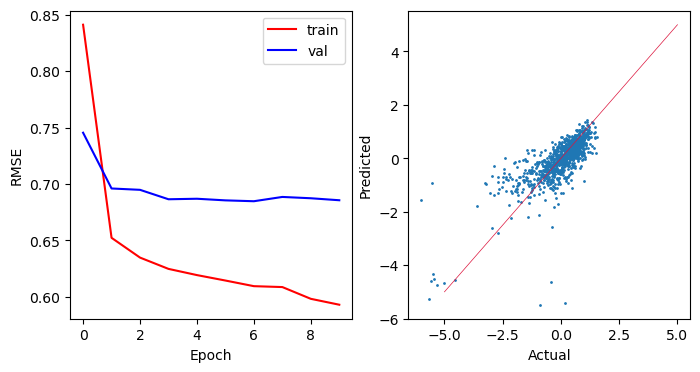

In [33]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [34]:
model5 = Sequential()
model5.add(Dense(40, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(20, activation='relu'))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 0.6800 - val_loss: 0.5701
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4252 - val_loss: 0.4973
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3959 - val_loss: 0.4803
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3852 - val_loss: 0.4771
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3811 - val_loss: 0.4683
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3759 - val_loss: 0.4688
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3667 - val_loss: 0.4624
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3646 - val_loss: 0.4632
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3608 - val_loss: 0.4608
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4432504334156

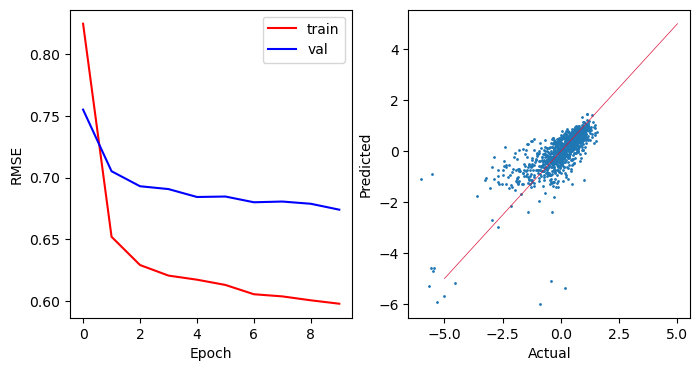

In [35]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [36]:
#2 layers
model5 = Sequential()
model5.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(15, activation='relu'))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 0.7067 - val_loss: 0.5438
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4392 - val_loss: 0.4810
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4060 - val_loss: 0.4697
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3926 - val_loss: 0.4702
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3836 - val_loss: 0.4670
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3791 - val_loss: 0.4645
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3733 - val_loss: 0.4580
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3666 - val_loss: 0.4614
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3605 - val_loss: 0.4663
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4140804081585

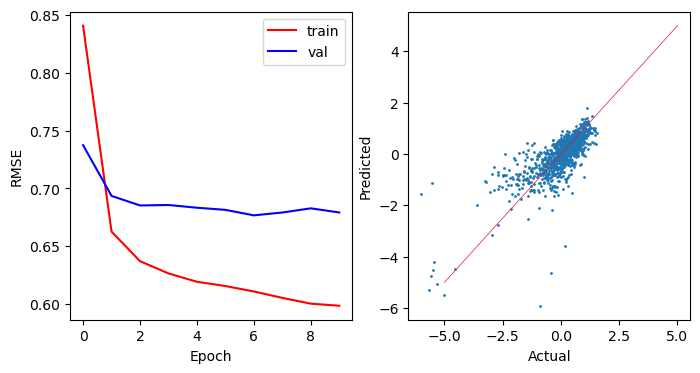

In [37]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [38]:
#reduce layer 2 parameters
model5 = Sequential()
model5.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(10, activation='relu'))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 5ms/step - loss: 1.3442 - val_loss: 0.8617
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.6460 - val_loss: 0.6428
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4852 - val_loss: 0.5373
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4316 - val_loss: 0.4990
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4129 - val_loss: 0.4807
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3986 - val_loss: 0.4766
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3907 - val_loss: 0.4724
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3843 - val_loss: 0.4688
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3798 - val_loss: 0.4649
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4357183348882

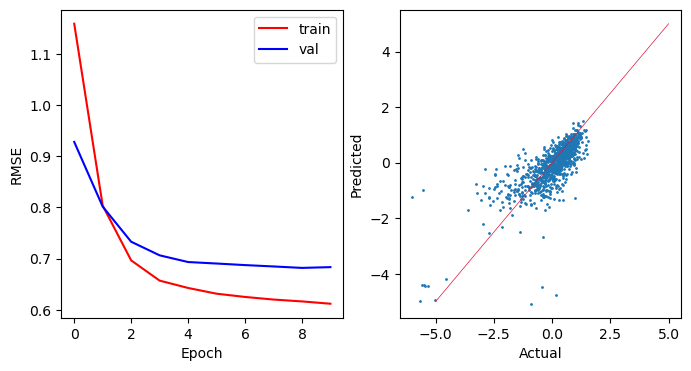

In [39]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [40]:
#1 hidden layer only
model5 = Sequential()
model5.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 2s 4ms/step - loss: 0.8122 - val_loss: 0.6367
Epoch 2/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4871 - val_loss: 0.5209
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4375 - val_loss: 0.4973
Epoch 4/10
106/106 [==============================] - 0s 2ms/step - loss: 0.4218 - val_loss: 0.4848
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4081 - val_loss: 0.4761
Epoch 6/10
106/106 [==============================] - 0s 2ms/step - loss: 0.4045 - val_loss: 0.4691
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3971 - val_loss: 0.4645
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3929 - val_loss: 0.4632
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3891 - val_loss: 0.4676
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4267562958996

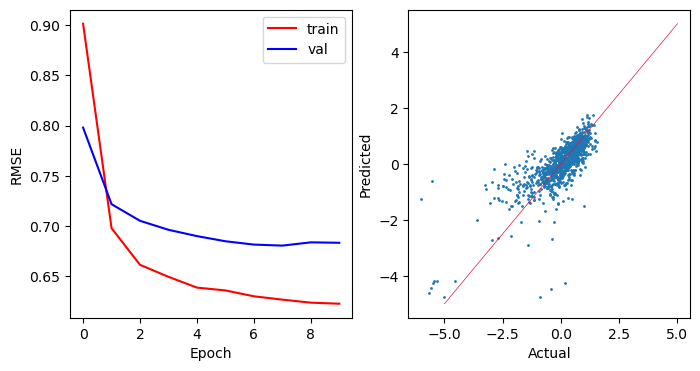

In [41]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [42]:
#1 hidden layer and 20 neurons only
model5 = Sequential()
model5.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
106/106 [==============================] - 1s 4ms/step - loss: 0.9770 - val_loss: 0.7116
Epoch 2/10
106/106 [==============================] - 0s 2ms/step - loss: 0.5023 - val_loss: 0.5274
Epoch 3/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4180 - val_loss: 0.5044
Epoch 4/10
106/106 [==============================] - 0s 3ms/step - loss: 0.4023 - val_loss: 0.4812
Epoch 5/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3935 - val_loss: 0.4899
Epoch 6/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3890 - val_loss: 0.4753
Epoch 7/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3859 - val_loss: 0.4774
Epoch 8/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3831 - val_loss: 0.4818
Epoch 9/10
106/106 [==============================] - 0s 3ms/step - loss: 0.3818 - val_loss: 0.4735
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4266580286677

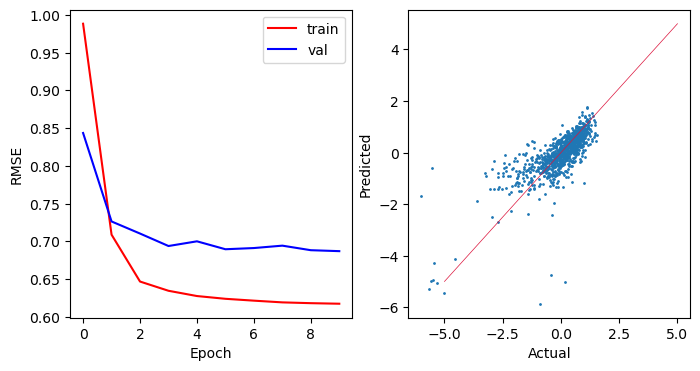

In [43]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

The network is starting to get too simple to learn the complexity of the training data with only 1 hidden layer and 20 neurons. The 1 hidden layer network with 30 neurons appears to give a comparable result with the more complex networks with 2 hidden layers. As the more complex models become overfit very quickly, we would prefer a simpler architecture.

We can further try increasing the batch size so that the model learns more slowly. 

#### Increase batch size

In [44]:
#2 layers, batch size 64
model5 = Sequential()
model5.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(10, activation='relu'))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 2s 8ms/step - loss: 0.8910 - val_loss: 0.7936
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5801 - val_loss: 0.5783
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4510 - val_loss: 0.5135
Epoch 4/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4135 - val_loss: 0.4928
Epoch 5/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3971 - val_loss: 0.4858
Epoch 6/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3875 - val_loss: 0.4822
Epoch 7/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3812 - val_loss: 0.4841
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3789 - val_loss: 0.4733
Epoch 9/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3725 - val_loss: 0.4732
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4427883822194543
test r-squared

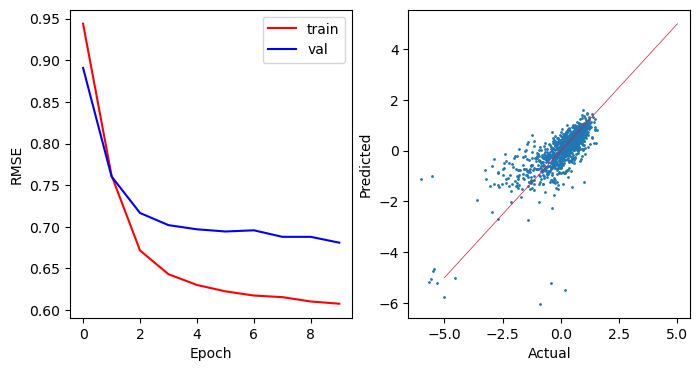

In [45]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

In [46]:
#1 layer , batch size 64
model5 = Sequential()
model5.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 0.9342 - val_loss: 0.7525
Epoch 2/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5454 - val_loss: 0.5759
Epoch 3/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4493 - val_loss: 0.5142
Epoch 4/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4162 - val_loss: 0.4862
Epoch 5/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4036 - val_loss: 0.4797
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3948 - val_loss: 0.4686
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3910 - val_loss: 0.4661
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3862 - val_loss: 0.4628
Epoch 9/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3819 - val_loss: 0.4632
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.42804627390329497
test r-square

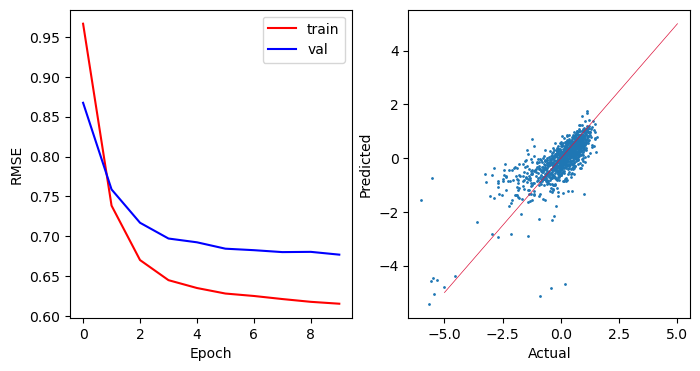

In [47]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

Increased batch size appears to stabilise the validation loss.

Next, we try if feature selection can improve the model performance. This will also help to show how different variables contribute to the model.

While neural networks are more robust against multicollinearity than linear regression, we can still see if removal of multicollinear variables improves the modle performance.

### Remove production countries

In [48]:
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country'])
y_train = df_train['st_log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country'])
y_test = df_test['st_log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country'])
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [49]:
#2 layers only
model5 = Sequential()
model5.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 1.1488 - val_loss: 0.8262
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6275 - val_loss: 0.6623
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5211 - val_loss: 0.5714
Epoch 4/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4651 - val_loss: 0.5187
Epoch 5/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4373 - val_loss: 0.4929
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4197 - val_loss: 0.4788
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4118 - val_loss: 0.4745
Epoch 8/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4036 - val_loss: 0.4707
Epoch 9/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3994 - val_loss: 0.4683
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4318666293094272
test r-squared

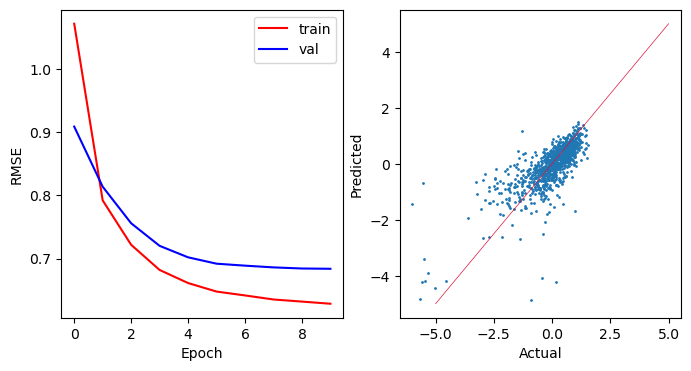

In [50]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

### Remove lanuage

In [51]:
X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'original_language_en', 'original_language_es', 'original_language_fr', 'original_language_it',
                                 'original_language_ja', 'original_language_ko', 'original_language_ru', 'original_language_ta', 
                                 'original_language_zh', 'original_language_others'])

y_train = df_train['st_log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'original_language_en', 'original_language_es', 'original_language_fr', 'original_language_it',
                                 'original_language_ja', 'original_language_ko', 'original_language_ru', 'original_language_ta', 
                                 'original_language_zh', 'original_language_others'])
y_test = df_test['st_log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'original_language_en', 'original_language_es', 'original_language_fr', 'original_language_it',
                                 'original_language_ja', 'original_language_ko', 'original_language_ru', 'original_language_ta', 
                                 'original_language_zh', 'original_language_others'])
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [52]:
#2 layers only
model5 = Sequential()
model5.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(1)) 

# compile and train model
model5.compile(optimizer='adam', loss='mean_squared_error')
model5_hist = model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 0.9394 - val_loss: 0.6308
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5105 - val_loss: 0.5118
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4357 - val_loss: 0.4824
Epoch 4/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4138 - val_loss: 0.4811
Epoch 5/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4044 - val_loss: 0.4749
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3982 - val_loss: 0.4711
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3954 - val_loss: 0.4674
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3919 - val_loss: 0.4723
Epoch 9/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3927 - val_loss: 0.4690
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4280239220351935
test r-squared

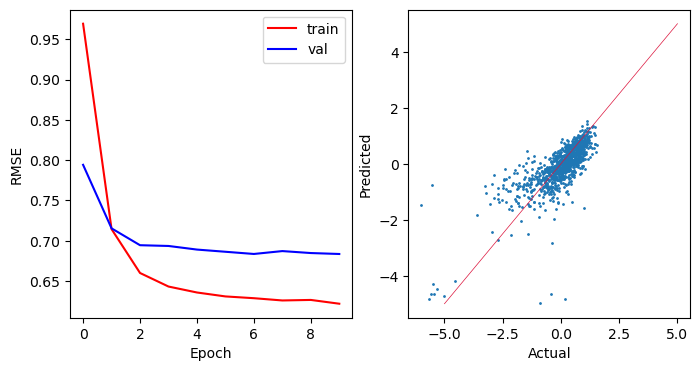

In [53]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model5_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model5_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

### Try without topics

In [54]:
#Create validation data from test data (train 0.7, test 0.2, val 0.1)
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'Topic_Topic 1', 
                                 'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5', 'Topic_Topic 6', 
                                 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9', 'Topic_Topic 10', 'series_ind'])
y_train = df_train['st_log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'Topic_Topic 1', 
                                 'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5', 'Topic_Topic 6', 
                                 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9', 'Topic_Topic 10', 'series_ind'])
y_test = df_test['st_log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'Topic_Topic 1', 
                                 'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5', 'Topic_Topic 6', 
                                 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9', 'Topic_Topic 10', 'series_ind'])
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [55]:
model6 = Sequential()
model6.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model6.add(Dense(1)) 

# compile and train model
model6.compile(optimizer='adam', loss='mean_squared_error')
model6_hist = model6.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model6.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 0.8462 - val_loss: 0.7282
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5636 - val_loss: 0.5675
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4657 - val_loss: 0.5071
Epoch 4/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4265 - val_loss: 0.4818
Epoch 5/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4110 - val_loss: 0.4742
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4017 - val_loss: 0.4729
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3985 - val_loss: 0.4706
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3932 - val_loss: 0.4676
Epoch 9/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3897 - val_loss: 0.4678
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4242966225594812
test r-squared

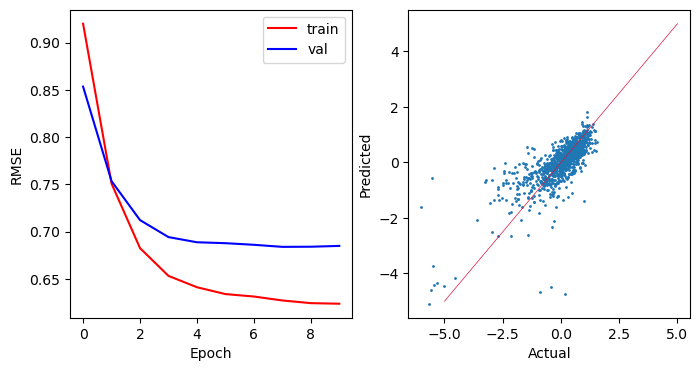

In [56]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model6_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model6_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

Removal of topics does not appear to affect model performance at all.

### Try without topics and production country

In [57]:
#Create validation data from test data (train 0.7, test 0.2, val 0.1)
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'Topic_Topic 1', 
                                 'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5', 'Topic_Topic 6', 
                                 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9', 'Topic_Topic 10', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country'])
y_train = df_train['st_log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'Topic_Topic 1', 
                                 'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5', 'Topic_Topic 6', 
                                 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9', 'Topic_Topic 10', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country'])
y_test = df_test['st_log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'Topic_Topic 1', 
                                 'Topic_Topic 2', 'Topic_Topic 3', 'Topic_Topic 4', 'Topic_Topic 5', 'Topic_Topic 6', 
                                 'Topic_Topic 7', 'Topic_Topic 8', 'Topic_Topic 9', 'Topic_Topic 10', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country'])
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [58]:
model7 = Sequential()
model7.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model7.add(Dense(1)) 

# compile and train model
model7.compile(optimizer='adam', loss='mean_squared_error')
model7_hist = model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model7.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 1.2971 - val_loss: 0.9349
Epoch 2/10
53/53 [==============================] - 0s 4ms/step - loss: 0.7252 - val_loss: 0.6465
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5229 - val_loss: 0.5261
Epoch 4/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4479 - val_loss: 0.4933
Epoch 5/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4228 - val_loss: 0.4811
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4113 - val_loss: 0.4731
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4035 - val_loss: 0.4713
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3976 - val_loss: 0.4706
Epoch 9/10
53/53 [==============================] - 0s 3ms/step - loss: 0.3950 - val_loss: 0.4714
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.43546065777389015
test r-square

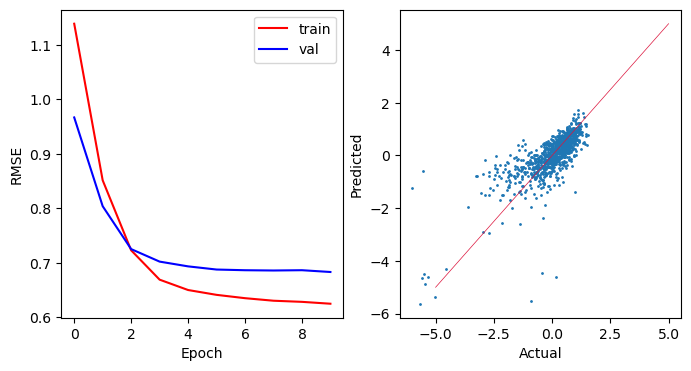

In [59]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model7_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model7_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual', fontsize=10)
ax[1].set_ylabel(r'Predicted', fontsize=10)

plt.show()

### Try backward stepwise regression vars

In [60]:
#Create validation data from test data (train 0.7, test 0.2, val 0.1)
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train[["st_runtime","st_log_budget_adj","Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                    "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                    "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                    "Walt Disney Pictures","Touchstone Pictures", "Other Prod", "series_num","top_director","st_total_cast",
                    "Topic_Topic 2"]]
y_train = df_train['st_log_revenue_adj']

X_test = df_test[["st_runtime","st_log_budget_adj","Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                    "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                    "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                    "Walt Disney Pictures","Touchstone Pictures", "Other Prod", "series_num","top_director","st_total_cast",
                    "Topic_Topic 2"]]
y_test = df_test['st_log_revenue_adj']

X_val = df_val[["st_runtime","st_log_budget_adj","Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                    "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                    "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                    "Walt Disney Pictures","Touchstone Pictures", "Other Prod", "series_num","top_director","st_total_cast",
                    "Topic_Topic 2"]]
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [61]:
X_train.shape[1]

23

In [62]:
model8 = Sequential()
model8.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model8.add(Dense(1)) 

# compile and train model
model8.compile(optimizer='adam', loss='mean_squared_error')
model8_hist = model8.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model8.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 1.1820 - val_loss: 0.9608
Epoch 2/10
53/53 [==============================] - 0s 4ms/step - loss: 0.6932 - val_loss: 0.6611
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5041 - val_loss: 0.5447
Epoch 4/10
53/53 [==============================] - 0s 3ms/step - loss: 0.4401 - val_loss: 0.5002
Epoch 5/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4161 - val_loss: 0.4832
Epoch 6/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4057 - val_loss: 0.4754
Epoch 7/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3994 - val_loss: 0.4731
Epoch 8/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3948 - val_loss: 0.4694
Epoch 9/10
53/53 [==============================] - 0s 4ms/step - loss: 0.3926 - val_loss: 0.4684
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.4265560674366352
test r-squared

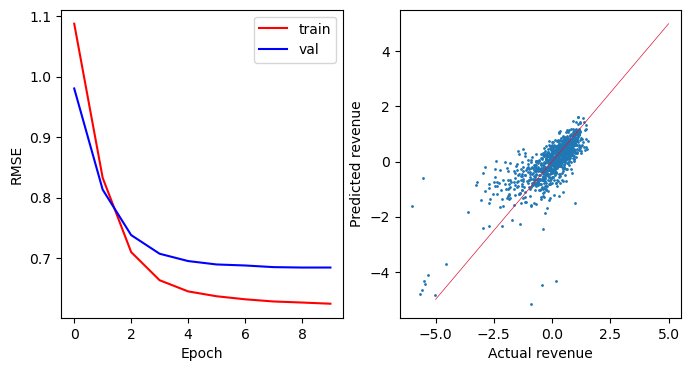

In [63]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model8_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model8_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual revenue', fontsize=10)
ax[1].set_ylabel(r'Predicted revenue', fontsize=10)

plt.show()

The model is overfitted. From the RMSE against epoch graph, we can see that most of the learning is completed around 3-4 epochs. We should terminate the model early to prevent further overfitting to the test data.

In [64]:
model8 = Sequential()
model8.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model8.add(Dense(1)) 

# compile and train model
model8.compile(optimizer='adam', loss='mean_squared_error')
model8_hist = model8.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model8.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/5
53/53 [==============================] - 1s 7ms/step - loss: 0.6498 - val_loss: 0.5792
Epoch 2/5
53/53 [==============================] - 0s 4ms/step - loss: 0.4639 - val_loss: 0.5022
Epoch 3/5
53/53 [==============================] - 0s 3ms/step - loss: 0.4256 - val_loss: 0.4887
Epoch 4/5
53/53 [==============================] - 0s 3ms/step - loss: 0.4131 - val_loss: 0.4829
Epoch 5/5
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.44104104434063784
test r-squared: 0.5513443103489675 ; test adjusted r-squared: 0.5404130806223003


This model has the best performance so far.

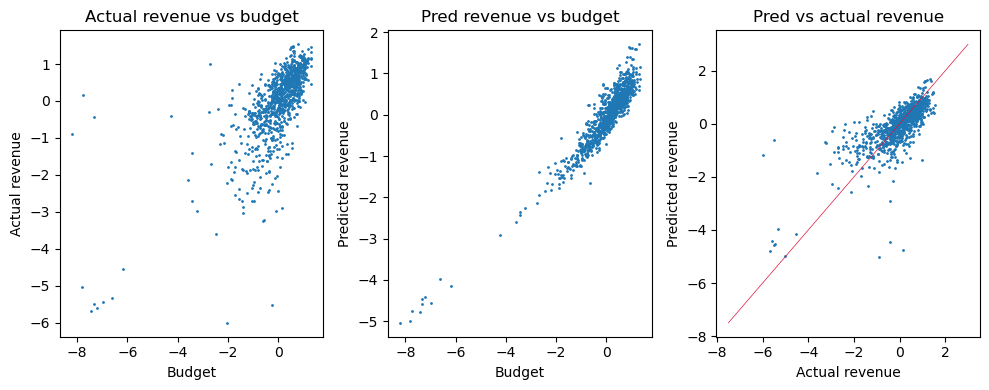

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].scatter(df_test['st_log_budget_adj'].values, y_test, s=1)
ax[0].set_xlabel(r'Budget', fontsize=10)
ax[0].set_ylabel(r'Actual revenue', fontsize=10)
ax[0].set_title('Actual revenue vs budget')


ax[1].scatter(df_test['st_log_budget_adj'].values, y_pred, s=1)
ax[1].set_xlabel(r'Budget', fontsize=10)
ax[1].set_ylabel(r'Predicted revenue', fontsize=10)
ax[1].set_title('Pred revenue vs budget')

ax[2].scatter(y_test, y_pred, s=1)
ax[2].plot([-7.5, 3], [-7.5,3], 'crimson', linewidth=0.5)
ax[2].set_xlabel(r'Actual revenue', fontsize=10)
ax[2].set_ylabel(r'Predicted revenue', fontsize=10)
ax[2].set_title('Pred vs actual revenue')

fig.tight_layout()

plt.show()

In [66]:
df_test['profit'] = np.where(df_test['revenue_adj']-df_test['budget_adj']>0, 1, 0)
df_test['pred_log_revenue'] = lrscaler.inverse_transform(y_pred)
df_test['pred_prodit'] = np.where(df_test['pred_log_revenue']-df_test['log_revenue_adj']>0, 1, 0)

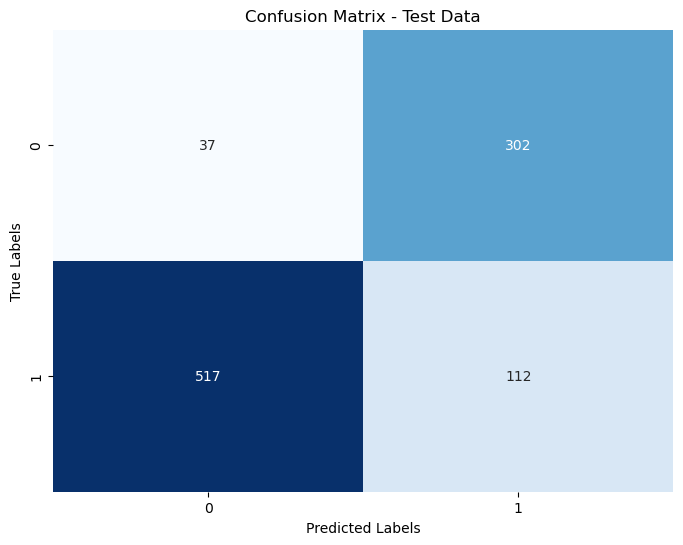

In [67]:
cm = confusion_matrix(df_test['profit'], df_test['pred_prodit'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [68]:
print("accuracy = ", (47+132)/len(y_test))

accuracy =  0.18491735537190082


### Try best model (stepwise vars) without budget

In [69]:
#Create validation data from test data (train 0.7, test 0.2, val 0.1)
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train[["st_runtime", "Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                    "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                    "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                    "Walt Disney Pictures","Touchstone Pictures", "Other Prod", "series_num","top_director","st_total_cast",
                    "Topic_Topic 2"]]
y_train = df_train['st_log_revenue_adj']

X_test = df_test[["st_runtime","Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                    "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                    "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                    "Walt Disney Pictures","Touchstone Pictures", "Other Prod", "series_num","top_director","st_total_cast",
                    "Topic_Topic 2"]] 
y_test = df_test['st_log_revenue_adj']

X_val = df_val[["st_runtime", "Animation","Comedy", "Drama","Family","Horror", "original_language_fr",
                    "original_language_hi", "original_language_ko","Warner Bros.", "Universal Pictures", 
                    "Paramount Pictures", "Twentieth Century Fox Film Corporation","Columbia Pictures","New Line Cinema",
                    "Walt Disney Pictures","Touchstone Pictures", "Other Prod", "series_num","top_director","st_total_cast",
                    "Topic_Topic 2"]]
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [70]:
model9 = Sequential()
model9.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model9.add(Dense(1)) 

# compile and train model
model9.compile(optimizer='adam', loss='mean_squared_error')
model9_hist = model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model9.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 0.8868 - val_loss: 0.8940
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 0.7516 - val_loss: 0.8142
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 0.7002 - val_loss: 0.7664
Epoch 4/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6710 - val_loss: 0.7430
Epoch 5/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6535 - val_loss: 0.7280
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6444 - val_loss: 0.7187
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6362 - val_loss: 0.7101
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6308 - val_loss: 0.7076
Epoch 9/10
53/53 [==============================] - 0s 3ms/step - loss: 0.6274 - val_loss: 0.7042
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.6009119483551401
test r-squared

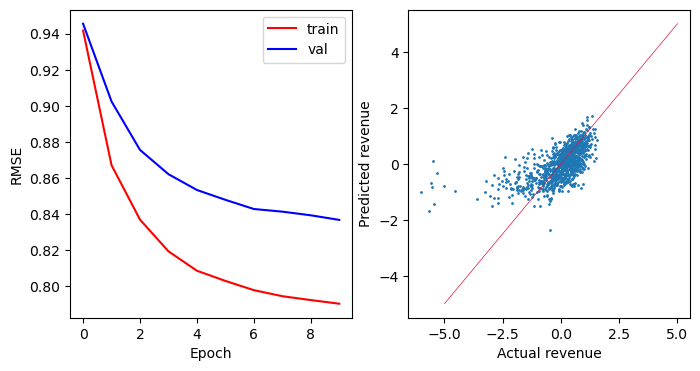

In [71]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model9_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model9_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual revenue', fontsize=10)
ax[1].set_ylabel(r'Predicted revenue', fontsize=10)

plt.show()

### Try no budget and no language

In [72]:
X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_budget_adj', 'st_log_revenue_adj', 'log_revenue_adj',
                                 'log_revenue_adj', 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 
                                 'series_ind', 'original_language_en', 'original_language_es', 'original_language_fr', 
                                 'original_language_it', 'original_language_ja', 'original_language_ko', 'original_language_ru',
                                 'original_language_ta', 'original_language_zh', 'original_language_others'])

y_train = df_train['st_log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_budget_adj', 'st_log_revenue_adj', 'log_revenue_adj',
                                 'log_revenue_adj', 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 
                                 'series_ind', 'original_language_en', 'original_language_es', 'original_language_fr', 
                                 'original_language_it', 'original_language_ja', 'original_language_ko', 'original_language_ru',
                                 'original_language_ta', 'original_language_zh', 'original_language_others'])
y_test = df_test['st_log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_budget_adj', 'st_log_revenue_adj', 'log_revenue_adj',
                                 'log_revenue_adj', 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 
                                 'series_ind', 'original_language_en', 'original_language_es', 'original_language_fr', 
                                 'original_language_it', 'original_language_ja', 'original_language_ko', 'original_language_ru',
                                 'original_language_ta', 'original_language_zh', 'original_language_others'])
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [73]:
model9 = Sequential()
model9.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model9.add(Dense(1)) 

# compile and train model
model9.compile(optimizer='adam', loss='mean_squared_error')
model9_hist = model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model9.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 7ms/step - loss: 0.9153 - val_loss: 0.8865
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 0.7228 - val_loss: 0.7786
Epoch 3/10
53/53 [==============================] - 0s 4ms/step - loss: 0.6457 - val_loss: 0.7135
Epoch 4/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5968 - val_loss: 0.6768
Epoch 5/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5629 - val_loss: 0.6352
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5358 - val_loss: 0.6232
Epoch 7/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5129 - val_loss: 0.5911
Epoch 8/10
53/53 [==============================] - 0s 4ms/step - loss: 0.4957 - val_loss: 0.5774
Epoch 9/10
53/53 [==============================] - 0s 5ms/step - loss: 0.4831 - val_loss: 0.5599
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5084148971542437
test r-squared

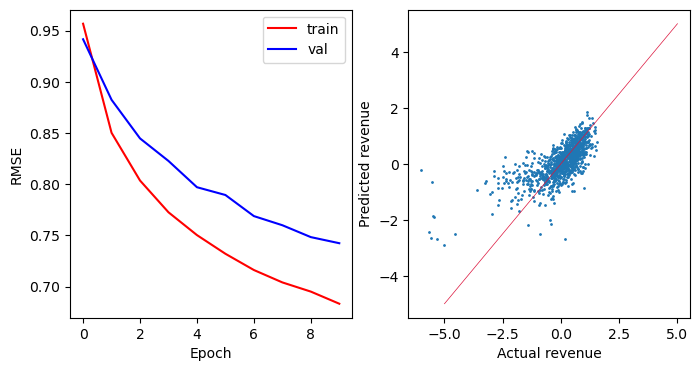

In [74]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model9_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model9_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual revenue', fontsize=10)
ax[1].set_ylabel(r'Predicted revenue', fontsize=10)

plt.show()

### Try no budget and no production country

In [75]:
df_test, df_val = train_test_split(test, test_size=0.33, random_state=2023)

X_train = df_train.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country', 'st_log_budget_adj'])
y_train = df_train['st_log_revenue_adj']

X_test = df_test.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country', 'st_log_budget_adj'])
y_test = df_test['st_log_revenue_adj']

X_val = df_val.drop(columns=['Unnamed: 0', 'id', 'title', 'st_log_revenue_adj', 'log_revenue_adj','log_revenue_adj', 
                                 'revenue_adj', 'budget_adj', 'total_cast', 'runtime', 'total_popular_cast', 'series_ind', 
                                 'United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 
                                 'Australia', 'Italy', 'Russia', 'Japan', 'Other Country', 'st_log_budget_adj'])
y_val = df_val['st_log_revenue_adj']

# Convert the DataFrame into numpy arrays
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

X_val = X_val.values
y_val = y_val.values

In [76]:
model9 = Sequential()
model9.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
model9.add(Dense(1)) 

# compile and train model
model9.compile(optimizer='adam', loss='mean_squared_error')
model9_hist = model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# evaluation
y_pred = model9.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Adjusted R squared = 1 - (1 - R-squared) * ((n - 1)/(n - p - 1))
rsquared = r2_score(y_test, y_pred)
n, p = len(y_test), np.shape(X_test)[1]
adj_rsquared = 1 - (1 - rsquared) * ((n - 1)/(n-p-1))
print("test r-squared:", rsquared, "; test adjusted r-squared:", adj_rsquared)


Epoch 1/10
53/53 [==============================] - 1s 9ms/step - loss: 0.9286 - val_loss: 0.9270
Epoch 2/10
53/53 [==============================] - 0s 4ms/step - loss: 0.7543 - val_loss: 0.8239
Epoch 3/10
53/53 [==============================] - 0s 4ms/step - loss: 0.6748 - val_loss: 0.7418
Epoch 4/10
53/53 [==============================] - 0s 4ms/step - loss: 0.6307 - val_loss: 0.6900
Epoch 5/10
53/53 [==============================] - 0s 4ms/step - loss: 0.5923 - val_loss: 0.6555
Epoch 6/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5663 - val_loss: 0.6334
Epoch 7/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5468 - val_loss: 0.6071
Epoch 8/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5266 - val_loss: 0.5808
Epoch 9/10
53/53 [==============================] - 0s 3ms/step - loss: 0.5078 - val_loss: 0.5658
Epoch 10/10
31/31 [==============================] - 0s 2ms/step
Mean Squared Error: 0.5001151989321959
test r-squared

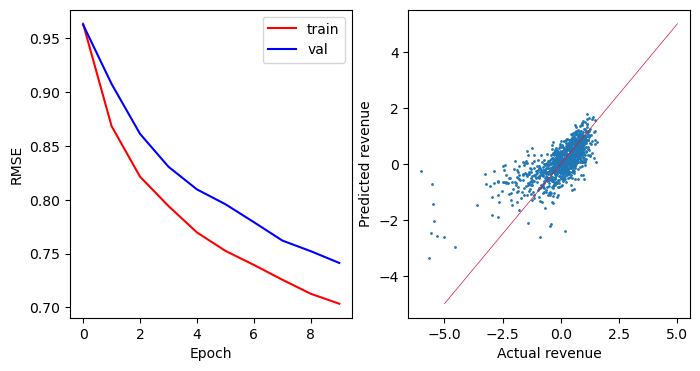

In [77]:
# Plot the loss function
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(np.sqrt(model9_hist.history['loss']), 'r', label='train')
ax[0].plot(np.sqrt(model9_hist.history['val_loss']), 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=10)
ax[0].set_ylabel(r'RMSE', fontsize=10)
ax[0].legend()
ax[0].tick_params(labelsize=10)

ax[1].scatter(y_test, y_pred, s=1)
ax[1].plot([-5, 5], [-5,5], 'crimson', linewidth=0.5)
ax[1].set_xlabel(r'Actual revenue', fontsize=10)
ax[1].set_ylabel(r'Predicted revenue', fontsize=10)

plt.show()